1. load the scenario

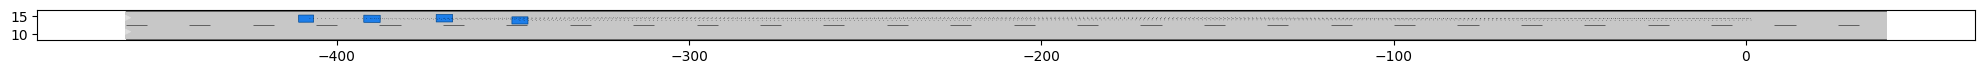

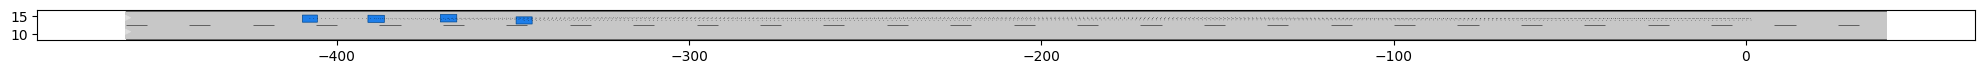

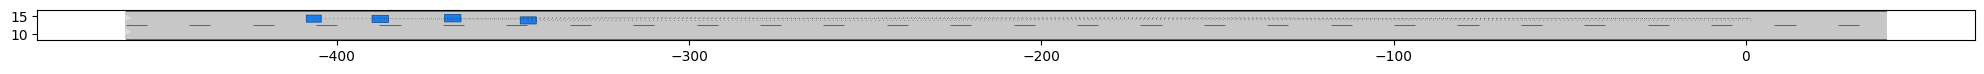

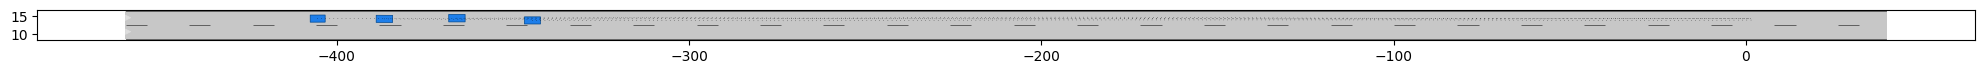

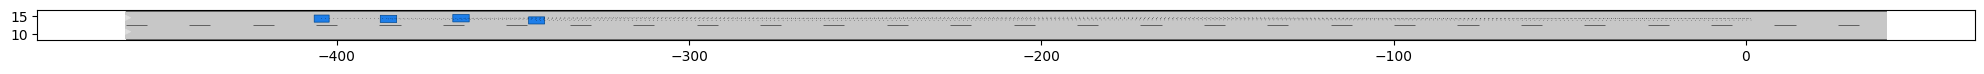

In [41]:
%matplotlib inline
import os
import scipy
from sre_parse import State
from turtle import position
import numpy as np
import pkg_resources
from cvxpy import *
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad.visualization.draw_params import DynamicObstacleParams


file_path = os.path.join(os.getcwd(), 'highD_01_T_1201-1800.xml')
# file_path = os.path.join(os.getcwd(), 'kernel_regression-1_0.xml') #   kernel_regression-1_0
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

for obs in scenario.obstacles:
    if obs.obstacle_id < 10067 or obs.obstacle_id > 10070: # or obs.obstacle_id == 10066:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

# scenario.remove_obstacle([scenario.obstacles[0],scenario.obstacles[1]])
translation = np.array([0.0, 0.0])
angle = np.pi

scenario.translate_rotate(translation, angle)
planning_problem_set.translate_rotate(translation, angle)

frame = 1342
for i in range(frame,frame+5):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    rnd.draw_params.time_end = 1800
    scenario.draw(rnd)
    rnd.render()

In [42]:
from cProfile import label
from scipy.stats import norm

path = 'D:\\learn\\23SS\\guided_research\\RL\\commonroad_io\\tutorials\\data_inter\\'  #os.path.abspath(os.path.dirname(__file__))
x_data = np.load(path + 'x_cur.npy')
matlab_data = scipy.io.loadmat(path + 'solution.mat')
solution_quad = scipy.io.loadmat(path + 'solution_quad.mat')
sol = matlab_data['x']
N_data = int((len(sol) - 1) / 2)
alphas = sol[:N_data]
alphas_quad = solution_quad['x_quad'][:3]


class Parameters:
    beta = 0.2
    dt = 0.04
    h = 0.913008
    A = np.array([[1, dt], [0, 1]])
    B = np.array([-dt * (h + dt), -dt])
    random_size = 30
    sigma = 0.6212


# # define optimal policy function
# def policy_kernel(x, x_data, alphas, p: Parameters):
#     sum_ = 0
#     for i in range(N_data):
#         sum_ += 2 * alphas[i] * x_data[i] * (1 + x_data[i] @ (p.A @ x))
#     return -p.beta * sum_ @ p.B


def policy_kernel(u, x, data, alp, p: Parameters):
    noises = norm.rvs(loc=0, scale=p.sigma, size=(p.random_size))
    sum_ = 0
    for noise in noises:
        for i in range(N_data):
            sum_ += 2 * alp[i] * data[i] * (1 + data[i] @ (p.A @ x + p.B *
                                                           (u + noise)))
    return u + p.beta * sum_ @ p.B / p.random_size


def policy_quadratic(x, alphas_quad, p: Parameters):
    a = alphas_quad
    x_next = p.A @ x
    return -p.beta * 2 * p.B @ np.array([
        a[0] * x_next[0] + a[1] * x_next[1],
        a[1] * x_next[0] + a[2] * x_next[1]
    ])


class TIConstraints:
    a_min = -8
    a_max = 15
    s_min = 0
    s_max = 150
    v_min = 0
    v_max = 35


def plot_state(x_p, pos, vel, data_pre, data_fol, p: Parameters):
    plt.figure(figsize=(10, 10))
    N = pos.shape[0] - 1

    # Plot (x_t)_1.
    plt.subplot(4, 1, 1)
    # x1 = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
    plt.plot(np.array(range(N + 1)), pos, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), data_fol[:, 0], 'b', label='data')
    plt.ylabel(r"$s$", fontsize=16)
    plt.legend()
    # plt.yticks(np.linspace(c.s_min, s_max, 3))
    # plt.ylim([c.s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4, 1, 2)
    plt.plot(np.array(range(N + 1)), vel, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), data_fol[:, 1], 'b', label='data')
    plt.ylabel(r"$v$", fontsize=16)
    plt.legend()
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4, 1, 3)
    x1 = x_p[:, 0] - pos - p.h * vel
    x1_data = data_pre[:, 0] - data_fol[:, 0] - p.h * data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x1, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), x1_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x1$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4, 1, 4)
    x2 = x_p[:, 1] - vel
    x2_data = data_pre[:, 1] - data_fol[:, 1]
    plt.plot(np.array(range(N + 1)), x2, 'g', label='IRL')
    plt.plot(np.array(range(N + 1)), x2_data, 'b', label='data')
    plt.legend()
    plt.ylabel(r"$x2$", fontsize=16)
    plt.xticks([])
    plt.xticks(np.arange(0, N + 1, 20))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    plt.show()

In [43]:
# problem data
N_vehicles = len(scenario.obstacles)
# N = 100  # number of time steps
n = 2  # length of state vector
m = 1  # length of input vector
dt = scenario.dt  # time step

# set up constraints
c = TIConstraints()
c.a_min = -6  # Minimum feasible acceleration of vehicle
c.a_max = 6  # Maximum feasible acceleration of vehicle
c.s_min = 0  # Minimum allowed position
c.s_max = 130  # Maximum allowed position
c.v_min = 0  # Minimum allowed velocity
c.v_max = 35  # Maximum allowed velocity (speed limit)

# set up system parameters
p = Parameters()

# weights for cost function
w_s = 0.0008
w_v = 0.9882  #0.9882
Q = np.eye(n) * np.transpose(np.array([w_s, w_v]))
w_u = 2.5
R = w_u
p.beta = 0.5 / R

# terms of system dynamic
p.h = 0.913008
p.A = np.array([[1, dt], [0, 1]])
p.B = np.array([-dt * (p.h + dt), -dt])

In [44]:
initial_frame = scenario.obstacles[-1].prediction.initial_time_step + 10
end_frame = scenario.obstacles[0].prediction.final_time_step
N_frames = end_frame - initial_frame
N = int(N_frames)
print(N_frames)

initial_states = np.zeros((N_vehicles, 3))
for i in range(len(scenario.obstacles)):
    obs = scenario.obstacles[i]
    initial_states[i, 0] = obs.state_at_time(initial_frame).position[0]
    initial_states[i, 1] = obs.state_at_time(initial_frame).position[1]
    initial_states[i, 2] = obs.state_at_time(initial_frame).velocity

states_data = []
for obs in scenario.obstacles:
    states_obs = np.zeros((N + 1, 2))
    for ii in range(N + 1):
        states_obs[ii, 0] = obs.state_at_time(initial_frame + ii).position[0]
        states_obs[ii, 1] = obs.state_at_time(initial_frame + ii).velocity
    states_data.append(states_obs)

print(len(states_data))

282
4


In [45]:
for obs in scenario.obstacles:
    if obs.obstacle_id != 10067:
        # print(obs.obstacle_id)
        scenario.remove_obstacle(obs)

vehicle pair i

[-5.71482934e-07]


C:\Users\zhaox\AppData\Local\Temp\ipykernel_28576\1650401548.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[0] = vf_weight * (u_kernel.x if kernel else policy_quadratic(
C:\Users\zhaox\AppData\Local\Temp\ipykernel_28576\1650401548.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[ii + 1] = vf_weight * (u_kernel.x if kernel else policy_quadratic(


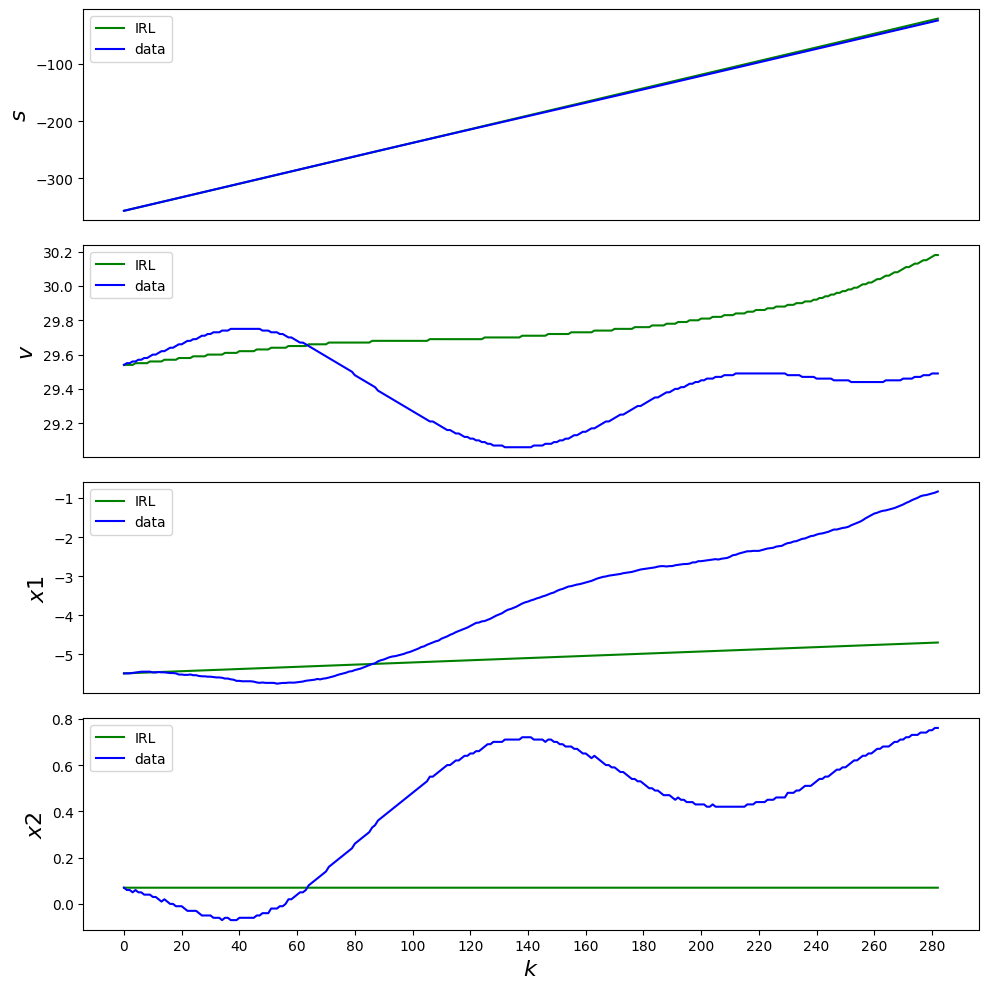

[-7.53893908e-07]


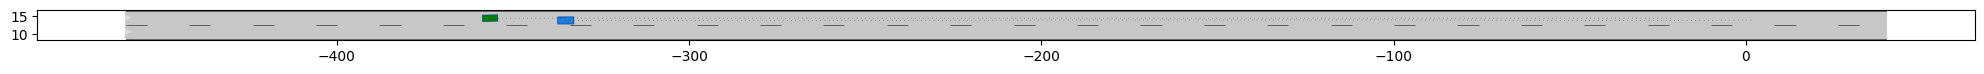

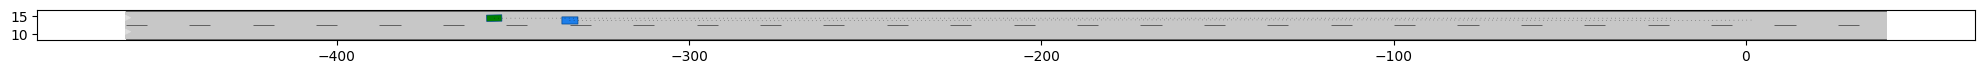

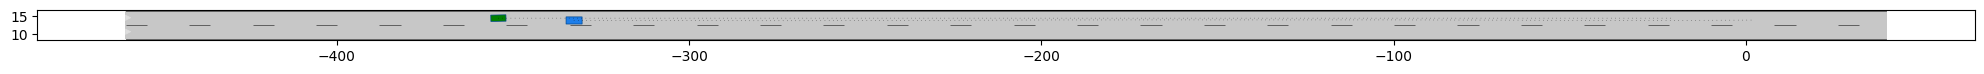

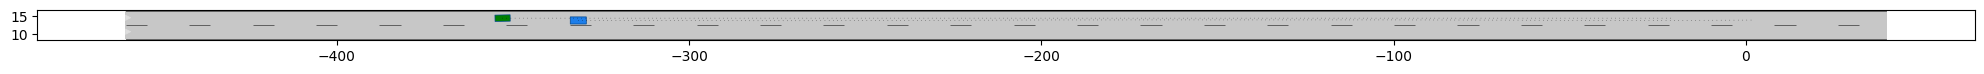

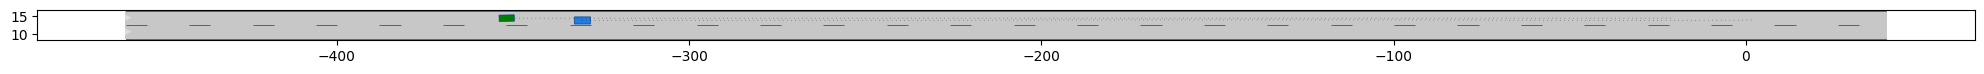

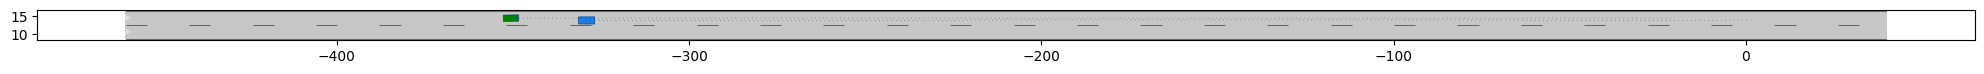

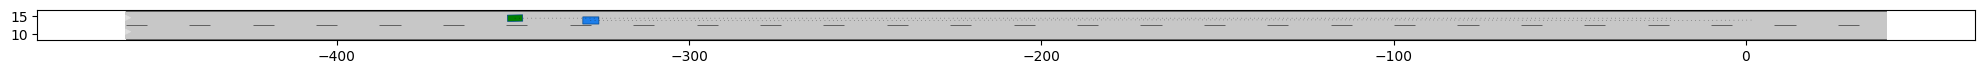

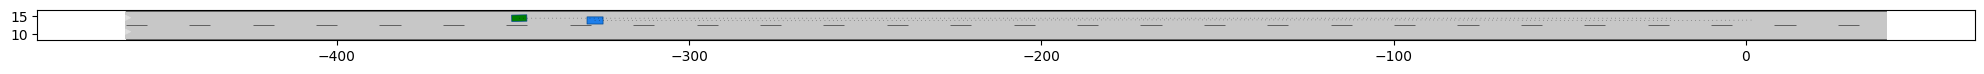

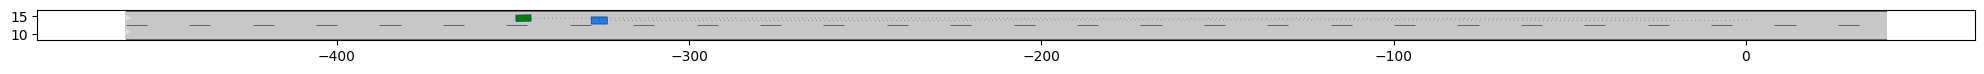

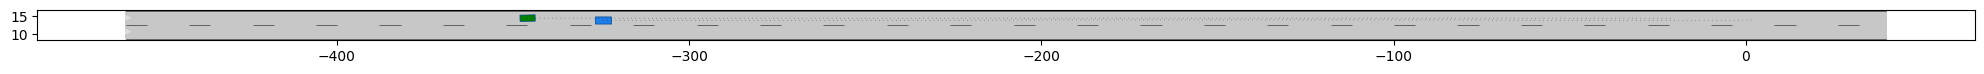

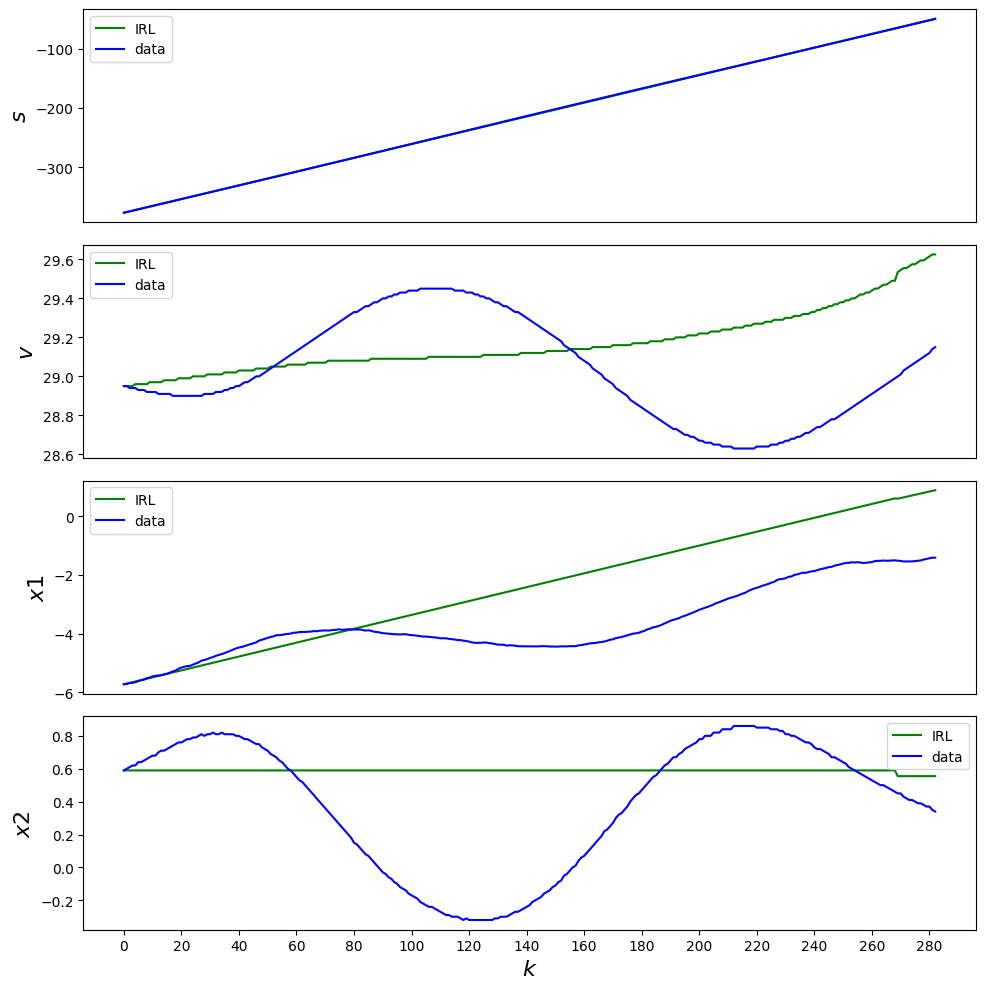

[-1.44888771e-07]


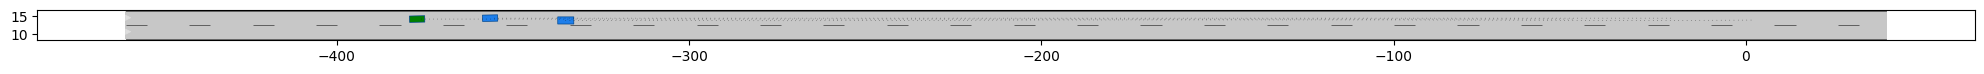

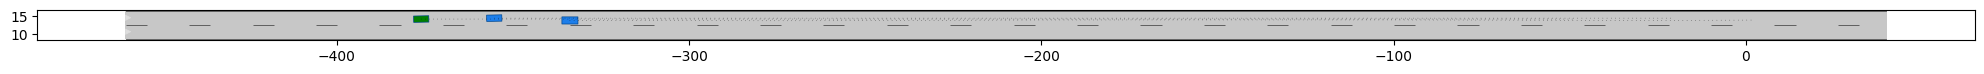

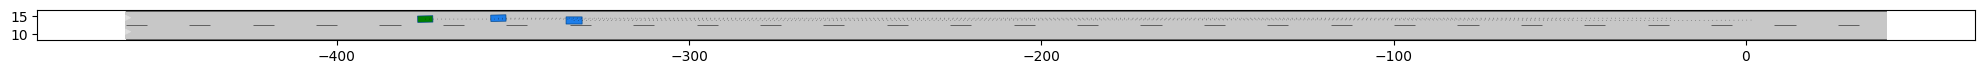

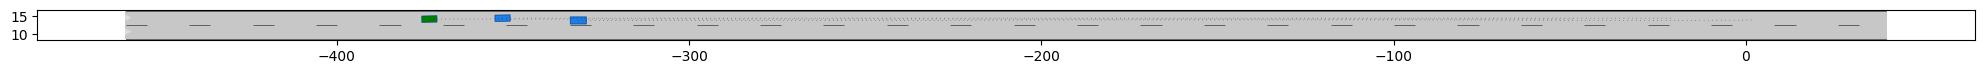

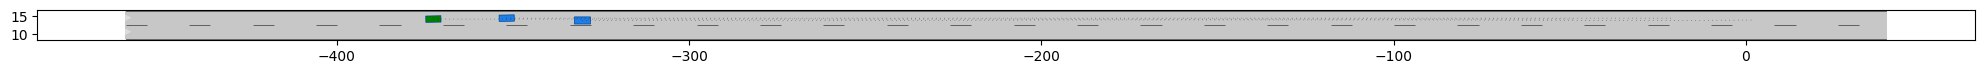

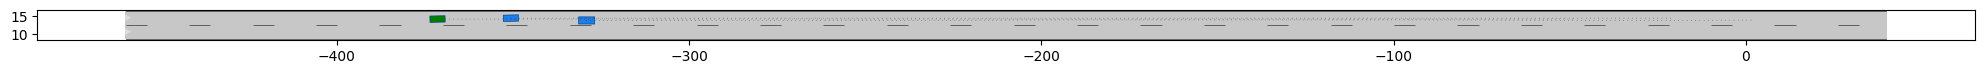

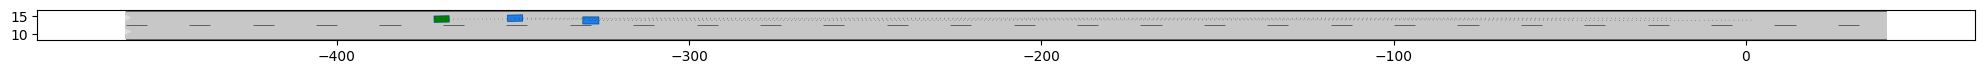

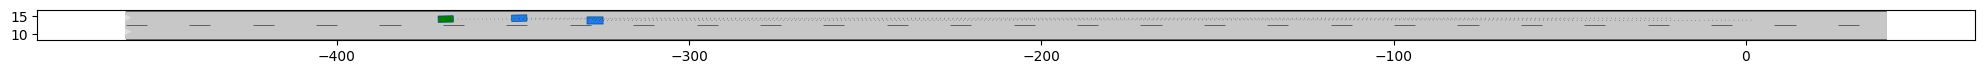

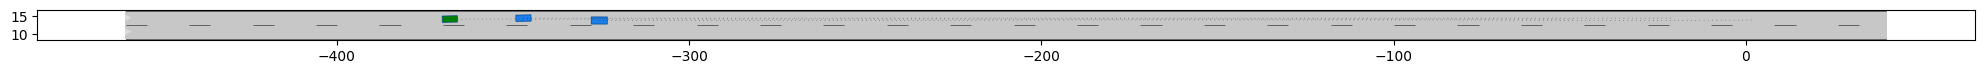

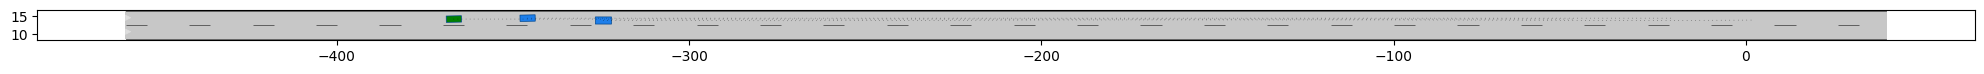

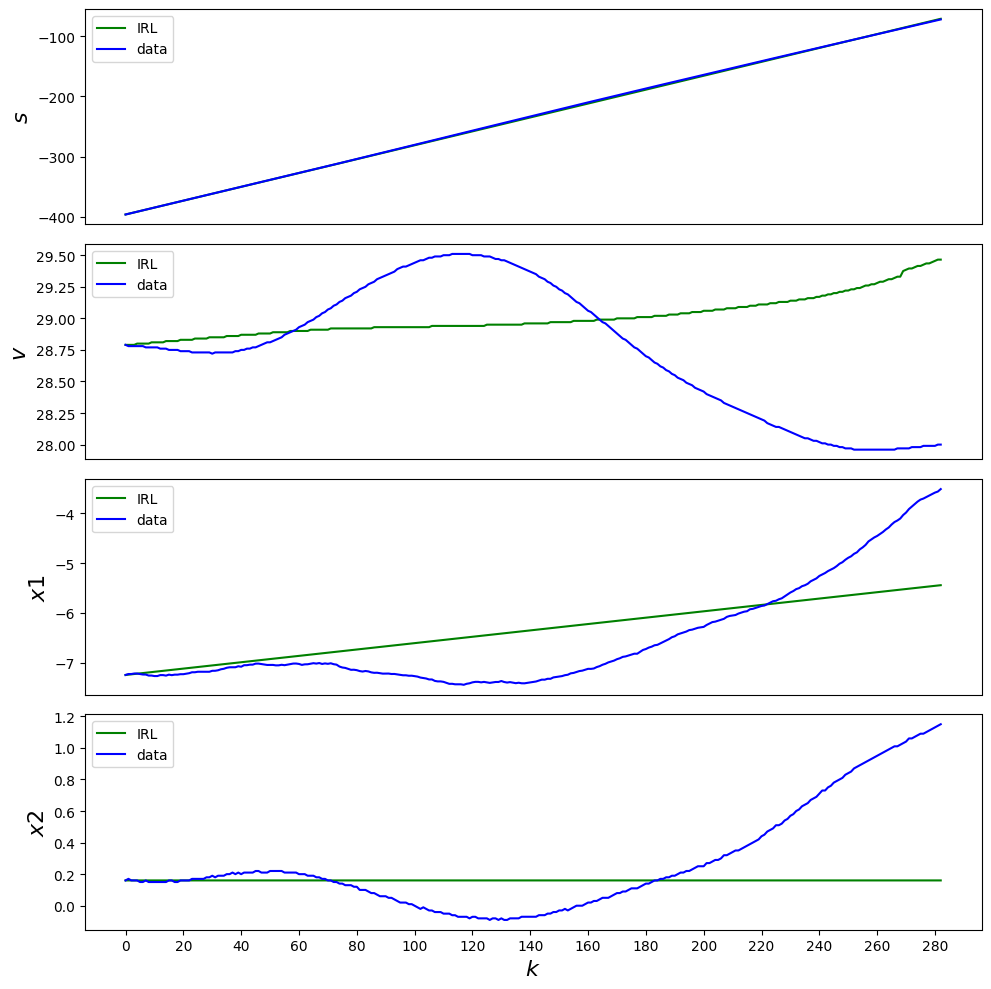

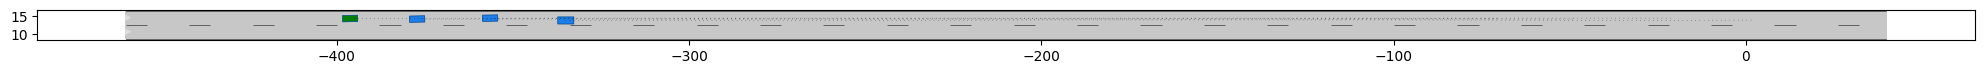

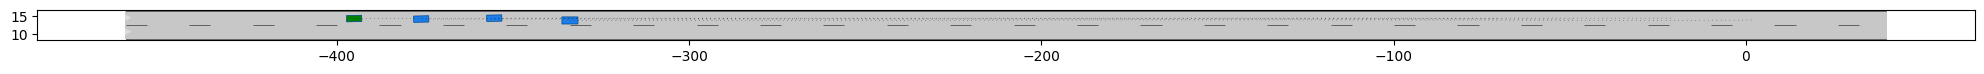

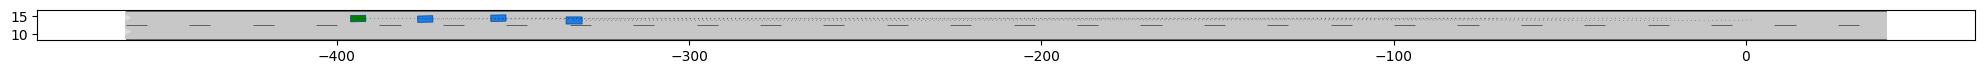

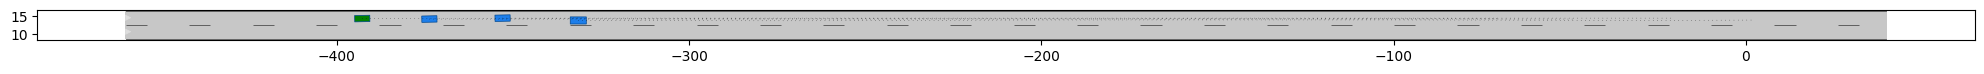

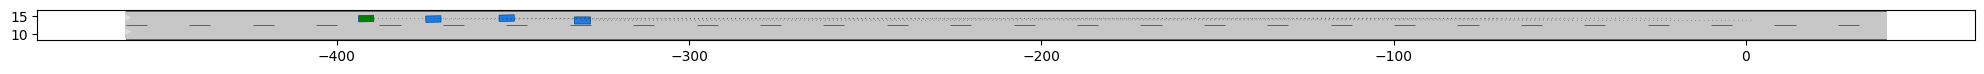

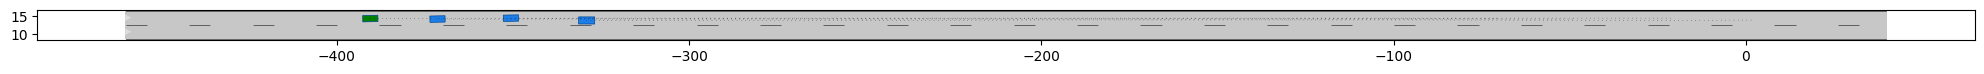

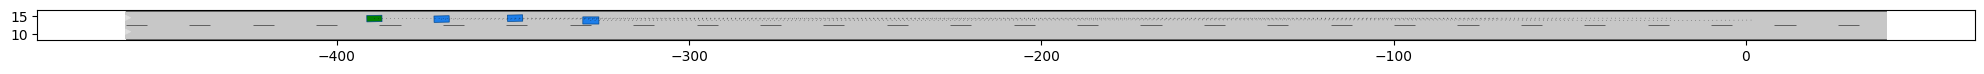

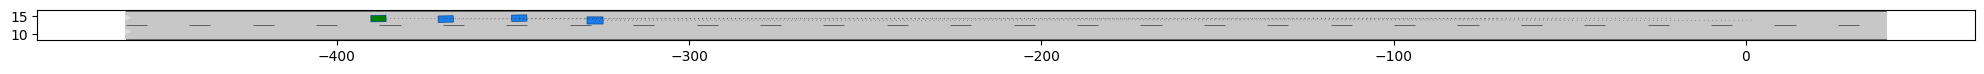

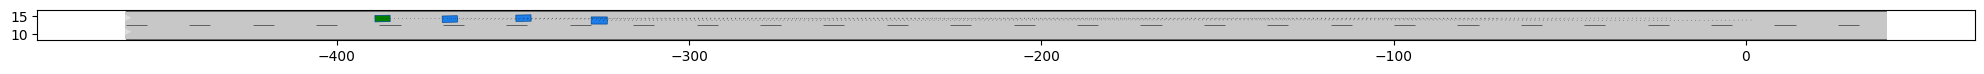

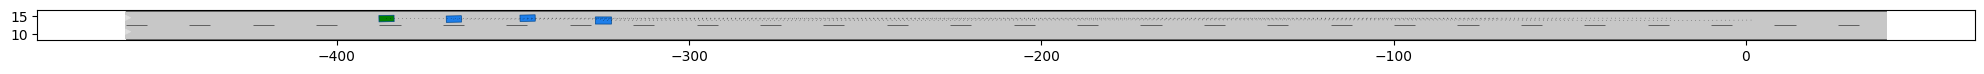

In [46]:
# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction
from scipy.optimize import root

for i in range(N_vehicles - 1):
    vehicle_pre = scenario.obstacles[i]
    x_pre = np.zeros((N + 1, 2))
    for ii in range(N + 1):
        x_pre[ii,
              0] = vehicle_pre.state_at_time(initial_frame + ii).position[0]
        x_pre[ii, 1] = vehicle_pre.state_at_time(initial_frame + ii).velocity
    # print(x_pre[0])

    initial_position = initial_states[i + 1, 0]
    initial_velocity = initial_states[i + 1, 2]

    x_ego_initial = np.array(
        [initial_position + p.h * initial_velocity, initial_velocity])
    # print(x_ego_initial)

    x_initial = x_pre[0, :] - x_ego_initial

    # print(x_initial)

    state_in_root_policy = x_initial

    def root_policy(u):
        return policy_kernel(u, state_in_root_policy, x_data, alphas, p)

    u_kernel = root(root_policy, 0)
    print(u_kernel.x)

    x = np.zeros((N + 1, 2))
    u = np.zeros(N + 1)
    x[0, :] = x_initial
    vf_weight = 5
    kernel = 1
    u[0] = vf_weight * (u_kernel.x if kernel else policy_quadratic(
        x_initial, alphas_quad, p))
    # u[0] = vf_weight * (policy_kernel(x_initial, x_data, alphas, p) if kernel
    #                     else policy_quadratic(x_initial, alphas_quad, p))

    for ii in range(N):
        x[ii + 1, :] = p.A @ x[ii, :] + p.B * u[ii]
        state_in_root_policy = x[ii + 1, :]
        u_kernel = root(root_policy, 0)
        u[ii + 1] = vf_weight * (u_kernel.x if kernel else policy_quadratic(
            x[ii + 1, :], alphas_quad, p))
        # u[ii + 1] = vf_weight * (policy_kernel(x[ii + 1, :], x_data, alphas, p)
        #                          if kernel else policy_quadratic(
        #                              x[ii + 1, :], alphas_quad, p))

    vel = x_pre[:, 1] - x[:, 1]
    pos = x_pre[:, 0] - x[:, 0] - p.h * vel
    # print(x)
    # print(u[:5])
    # print(pos[:5])

    plot_state(x_pre, pos, vel, states_data[i], states_data[i + 1], p)
    ###################

    # initial state has a time step of 0
    dynamic_obstacle_initial_state = CustomState(
        position=np.array([pos[0], initial_states[i + 1, 1]]),
        velocity=vel[0],
        orientation=0.02,
        time_step=initial_frame).convert_state_to_state(InitialState())

    # generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity

    state_list = [
        CustomState(position=np.array([pos[j], initial_states[i + 1, 1]]),
                    velocity=vel[j],
                    orientation=0.02,
                    time_step=initial_frame + j) for j in range(1, N + 1)
    ]
    # print(state_list[:10])

    # create the trajectory of the obstacle, starting at time step 1
    dynamic_obstacle_trajectory = Trajectory(initial_frame + 1, state_list)

    # create the prediction using the trajectory and the shape of the obstacle
    dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
    dynamic_obstacle_prediction = TrajectoryPrediction(
        dynamic_obstacle_trajectory, dynamic_obstacle_shape)

    # generate the dynamic obstacle according to the specification
    dynamic_obstacle_id = scenario.generate_object_id()
    dynamic_obstacle_type = ObstacleType.CAR
    dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id,
                                       dynamic_obstacle_type,
                                       dynamic_obstacle_shape,
                                       dynamic_obstacle_initial_state,
                                       dynamic_obstacle_prediction)
    ego_vehicle = dynamic_obstacle

    # plot the scenario and the ego vehicle for each time step
    ego_params = DynamicObstacleParams()
    ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
    for ii in range(initial_frame, initial_frame + 10):
        plt.figure(figsize=(25, 10))
        rnd = MPRenderer()
        rnd.draw_params.time_begin = ii
        rnd.draw_params.time_end = 1800
        scenario.draw(rnd)
        ego_params.time_begin = ii
        ego_params.time_end = 1800
        ego_vehicle.draw(rnd, draw_params=ego_params)
        rnd.render()

    # add dynamic obstacle to the scenario
    scenario.add_objects(ego_vehicle)


Simple Scenario where only two vehicles are involved:

In [ ]:
x_pre = np.zeros((N + 1, 2))
for i in range(N + 1):
    x_pre[i, 0] = scenario.obstacles[0].state_at_time(i).position[0]
    x_pre[i, 1] = scenario.obstacles[0].state_at_time(i).velocity

# print(x_pre)

In [ ]:
initial_position = 15
initial_velocity = 20

x_0 = np.array([initial_position + h * initial_velocity,
                initial_velocity])  # initial state

# Set up optimization problem
cost = 0
# initial state constraint
constr = [x[:, 0] == x_0]

for k in range(N):
    # cost function
    cost += quad_form(x_pre[:, k + 1] - x[:, k + 1], Q) + R * u[k]**2
    # time variant state and input constraints
    constr.append((x_pre[:, k + 1] -
                   x[:, k + 1]) == A @ (x_pre[:, k] - x[:, k]) + B * u[k])

# sums problem objectives and concatenates constraints.
# create optimization problem
prob = Problem(Minimize(cost), constr)

# Solve optimization problem
prob.solve(verbose=True)
# print("Problem is convex: ", prob.is_dcp())
# print("Problem solution is " + prob.status)

plot_state_vector(x, TIConstraints(), x_p=x_pre)

# print(x_pre[0, :])
# print((x.value)[0, :].flatten())
# print((x.value)[1, :].flatten())
# print(x)

In [ ]:
import numpy as np
# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import ObstacleType, DynamicObstacle
from commonroad.scenario.state import InitialState, CustomState
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

pos = (x.value)[0, :].flatten() - h * (x.value)[1, :].flatten()
vel = (x.value)[1, :].flatten()

# initial state has a time step of 0
dynamic_obstacle_initial_state = CustomState(
    position=np.array([pos[0], 0]),
    velocity=vel[0],
    orientation=0.02,
    time_step=0).convert_state_to_state(InitialState())

# generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity

state_list = [
    CustomState(position=np.array([pos[i], 0]),
                velocity=vel[i],
                orientation=0.02,
                time_step=i) for i in range(1, N + 1)
]
print(state_list)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory,
                                                   dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, dynamic_obstacle_type,
                                   dynamic_obstacle_shape,
                                   dynamic_obstacle_initial_state,
                                   dynamic_obstacle_prediction)
ego_vehicle = dynamic_obstacle
# # add dynamic obstacle to the scenario
# scenario.add_objects(dynamic_obstacle)

# plot the scenario and the ego vehicle for each time step
ego_params = DynamicObstacleParams()
ego_params.vehicle_shape.occupancy.shape.facecolor = "g"
for i in range(0, N + 1):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    ego_params.time_begin = i
    ego_vehicle.draw(rnd, draw_params=ego_params)
    planning_problem_set.draw(rnd)
    rnd.render()

# # plot the scenario for each time step
# for i in range(0, 41):
#     plt.figure(figsize=(25, 10))
#     rnd = MPRenderer()
#     rnd.draw_params.time_begin = i
#     scenario.draw(rnd)
#     planning_problem_set.draw(rnd)
#     rnd.render()